# Problem Statement
Write a program to implement Simplified Advanced Encryption Standard (S–AES)

#S-AES Key Points

* Simplified Advanced Encryption Standard
* similar properties and structure to AES with much smaller parameters
* designed for educational purposes
* symmetric key algorithm
* block cipher key
* key - shared secret
* substitution-permutation network

* functions of encryption and decryption
  * add round key - xor input with subkey
  * nibble substitution - s-box encryption
  * shift row - replace 2nd and 4th nibble
  * mix columns - matrix multiplication

* Key Generation
  * Input - 16 bit key
  * Output - 3 16 bit sub keys {key0, key1, key2}
  * Mathematical Notation
    * w0 = key[0:8]
    * w1 = key[8:]
    * w2 = w0 ^ [1,0,0,0,0,0,0,0] ^ sub_nib(rot_nib(w1))
    * w3 = w1 ^ w2
    * w4 = w2 ^ [0,0,1,1,0,0,0,0] ^ sub_nib(rot_nib(w3))
    * w5 = w3 ^ w4
    * key0 = key
    * key1 = w2w3
    * key2 = w4w5

* Encryption
  * Input - 16 bit plain text, 16 bit key
  * Output - 16 bit cipher text
  * cipher_text = ShRow(NibSub(MixCol(ShRow(NibSub(plain_text^key0)))^key1))^key2

* Decryption
  * Input - 16 bit cipher text, 16 bit key
  * Output - 16 bit plain text
  * decrypted_text = InvNibSub(InvShRow(InvMixCol((InvNibSub(InvShRow(cipher_text^key2)))^key1)))^key0


* The 16 bit key in turn produces three subkeys k1, k2 and k3; which are used once each during encryption and decryption

* Mathematical Notations
  * key generation
    * w0 = key[0:8]
    * w1 = key[8:]
    * w2 = w0 ^ [1,0,0,0,0,0,0,0] ^ sub_nib(rot_nib(w1))
    * w3 = w1 ^ w2
    * w4 = w2 ^ [0,0,1,1,0,0,0,0] ^ sub_nib(rot_nib(w3))
    * w5 = w3 ^ w4
    * key0 = key
    * key1 = w2w3
    * key2 = w4w5
  * cipher_text = ShRow(NibSub(MixCol(ShRow(NibSub(plain_text^key0)))^key1))^key2
  * decrypted_text = InvNibSub(InvShRow(InvMixCol((InvNibSub(InvShRow(cipher_text^key2)))^key1)))^key0

* Advantages
  * easily comprehendable, useful for educational purposes

* Disadvantages
  * Not fit for security encryption
  * A brute-force attack on 16-bit key is certainly feasible
  * shared secret

#Important Diagrams

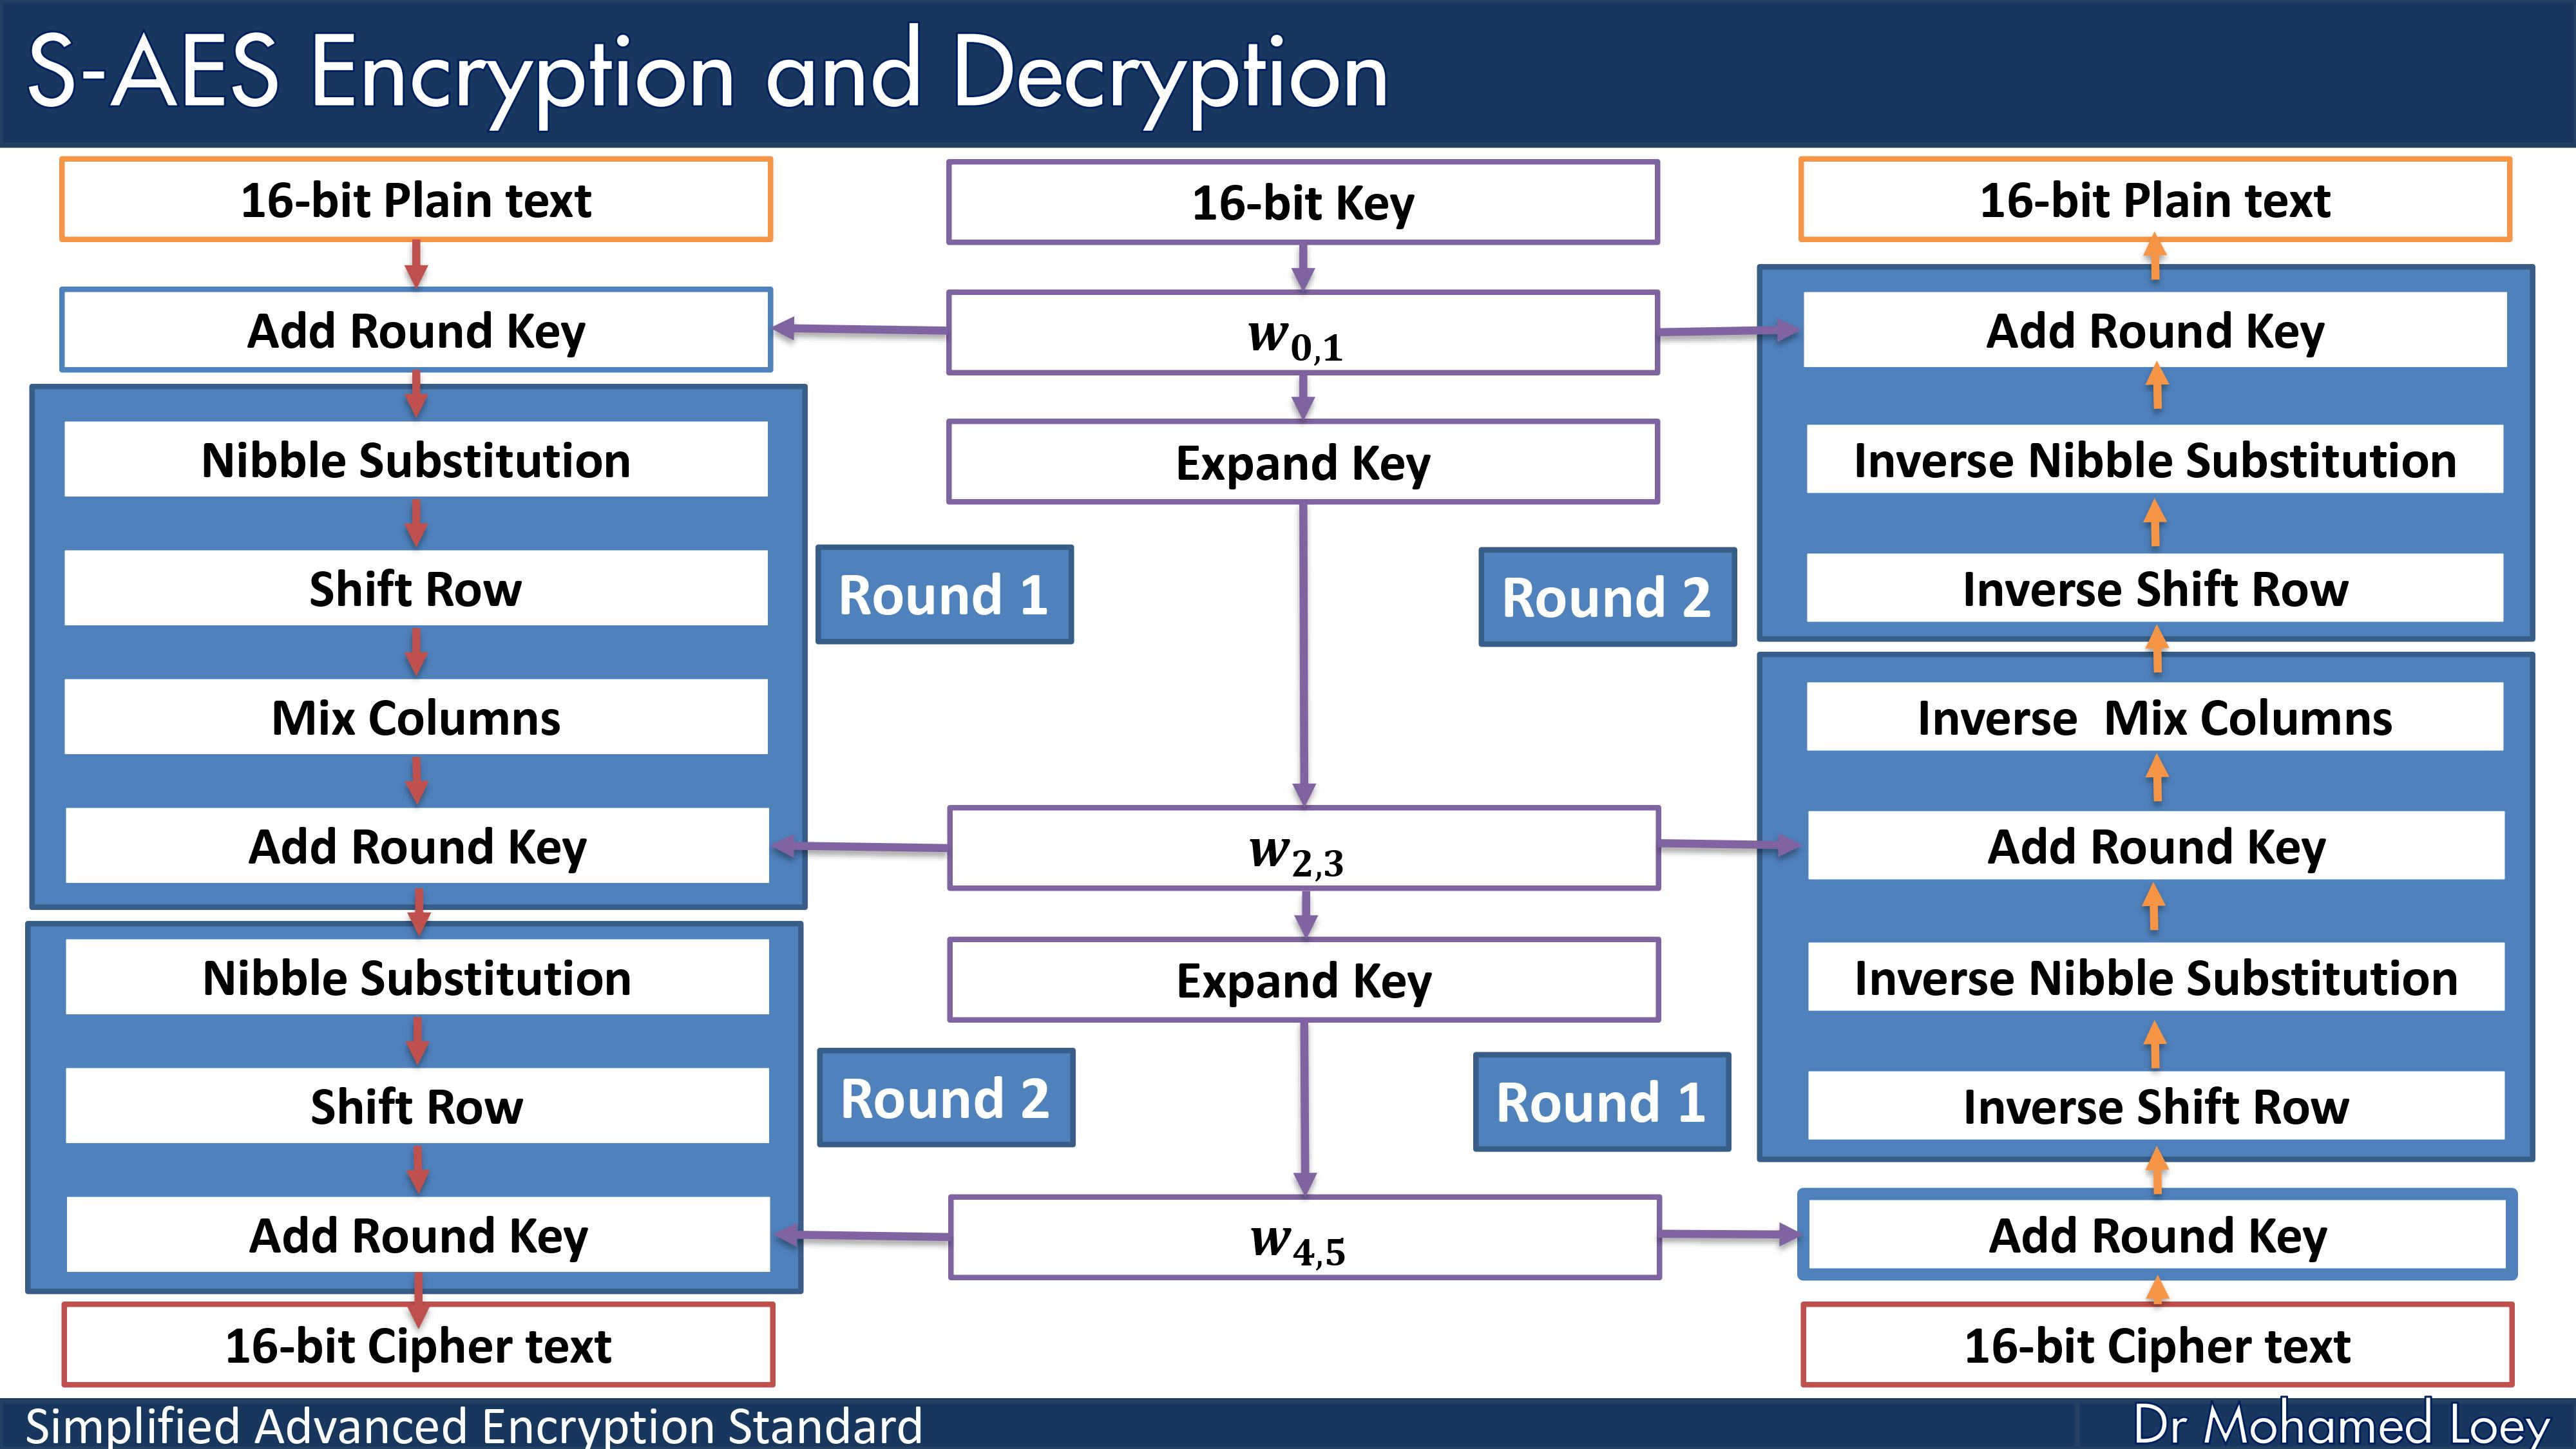

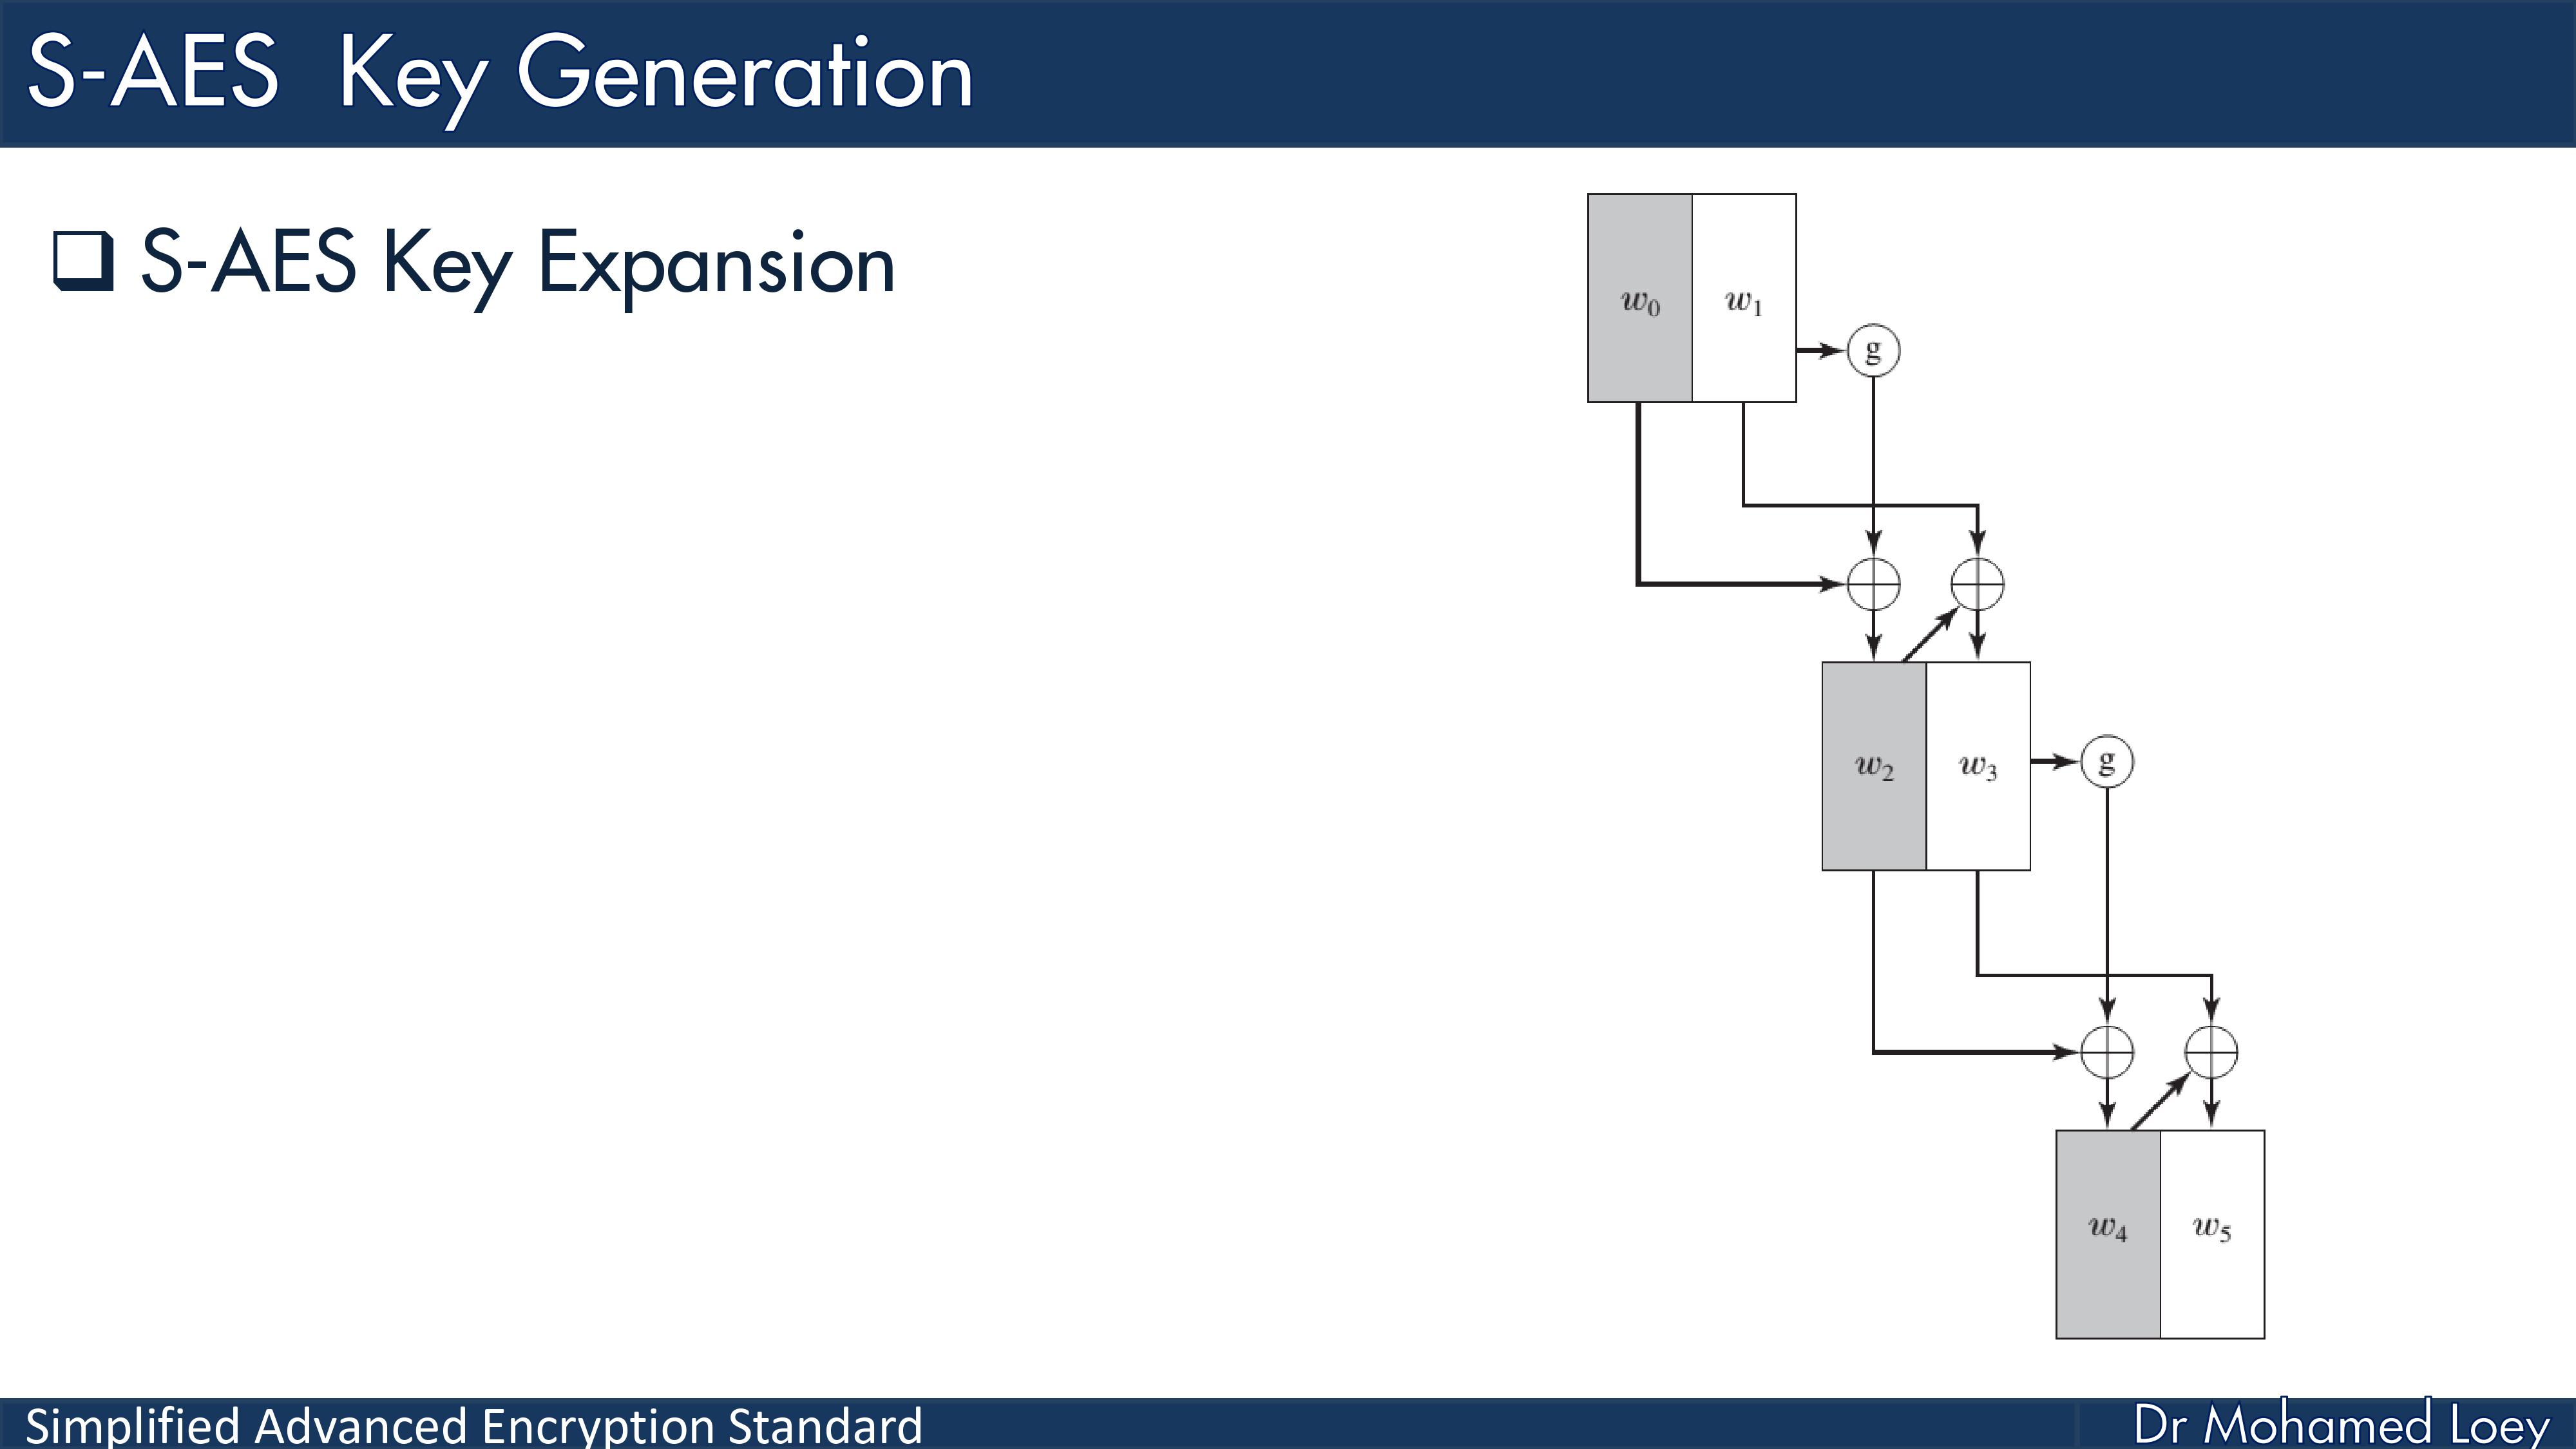

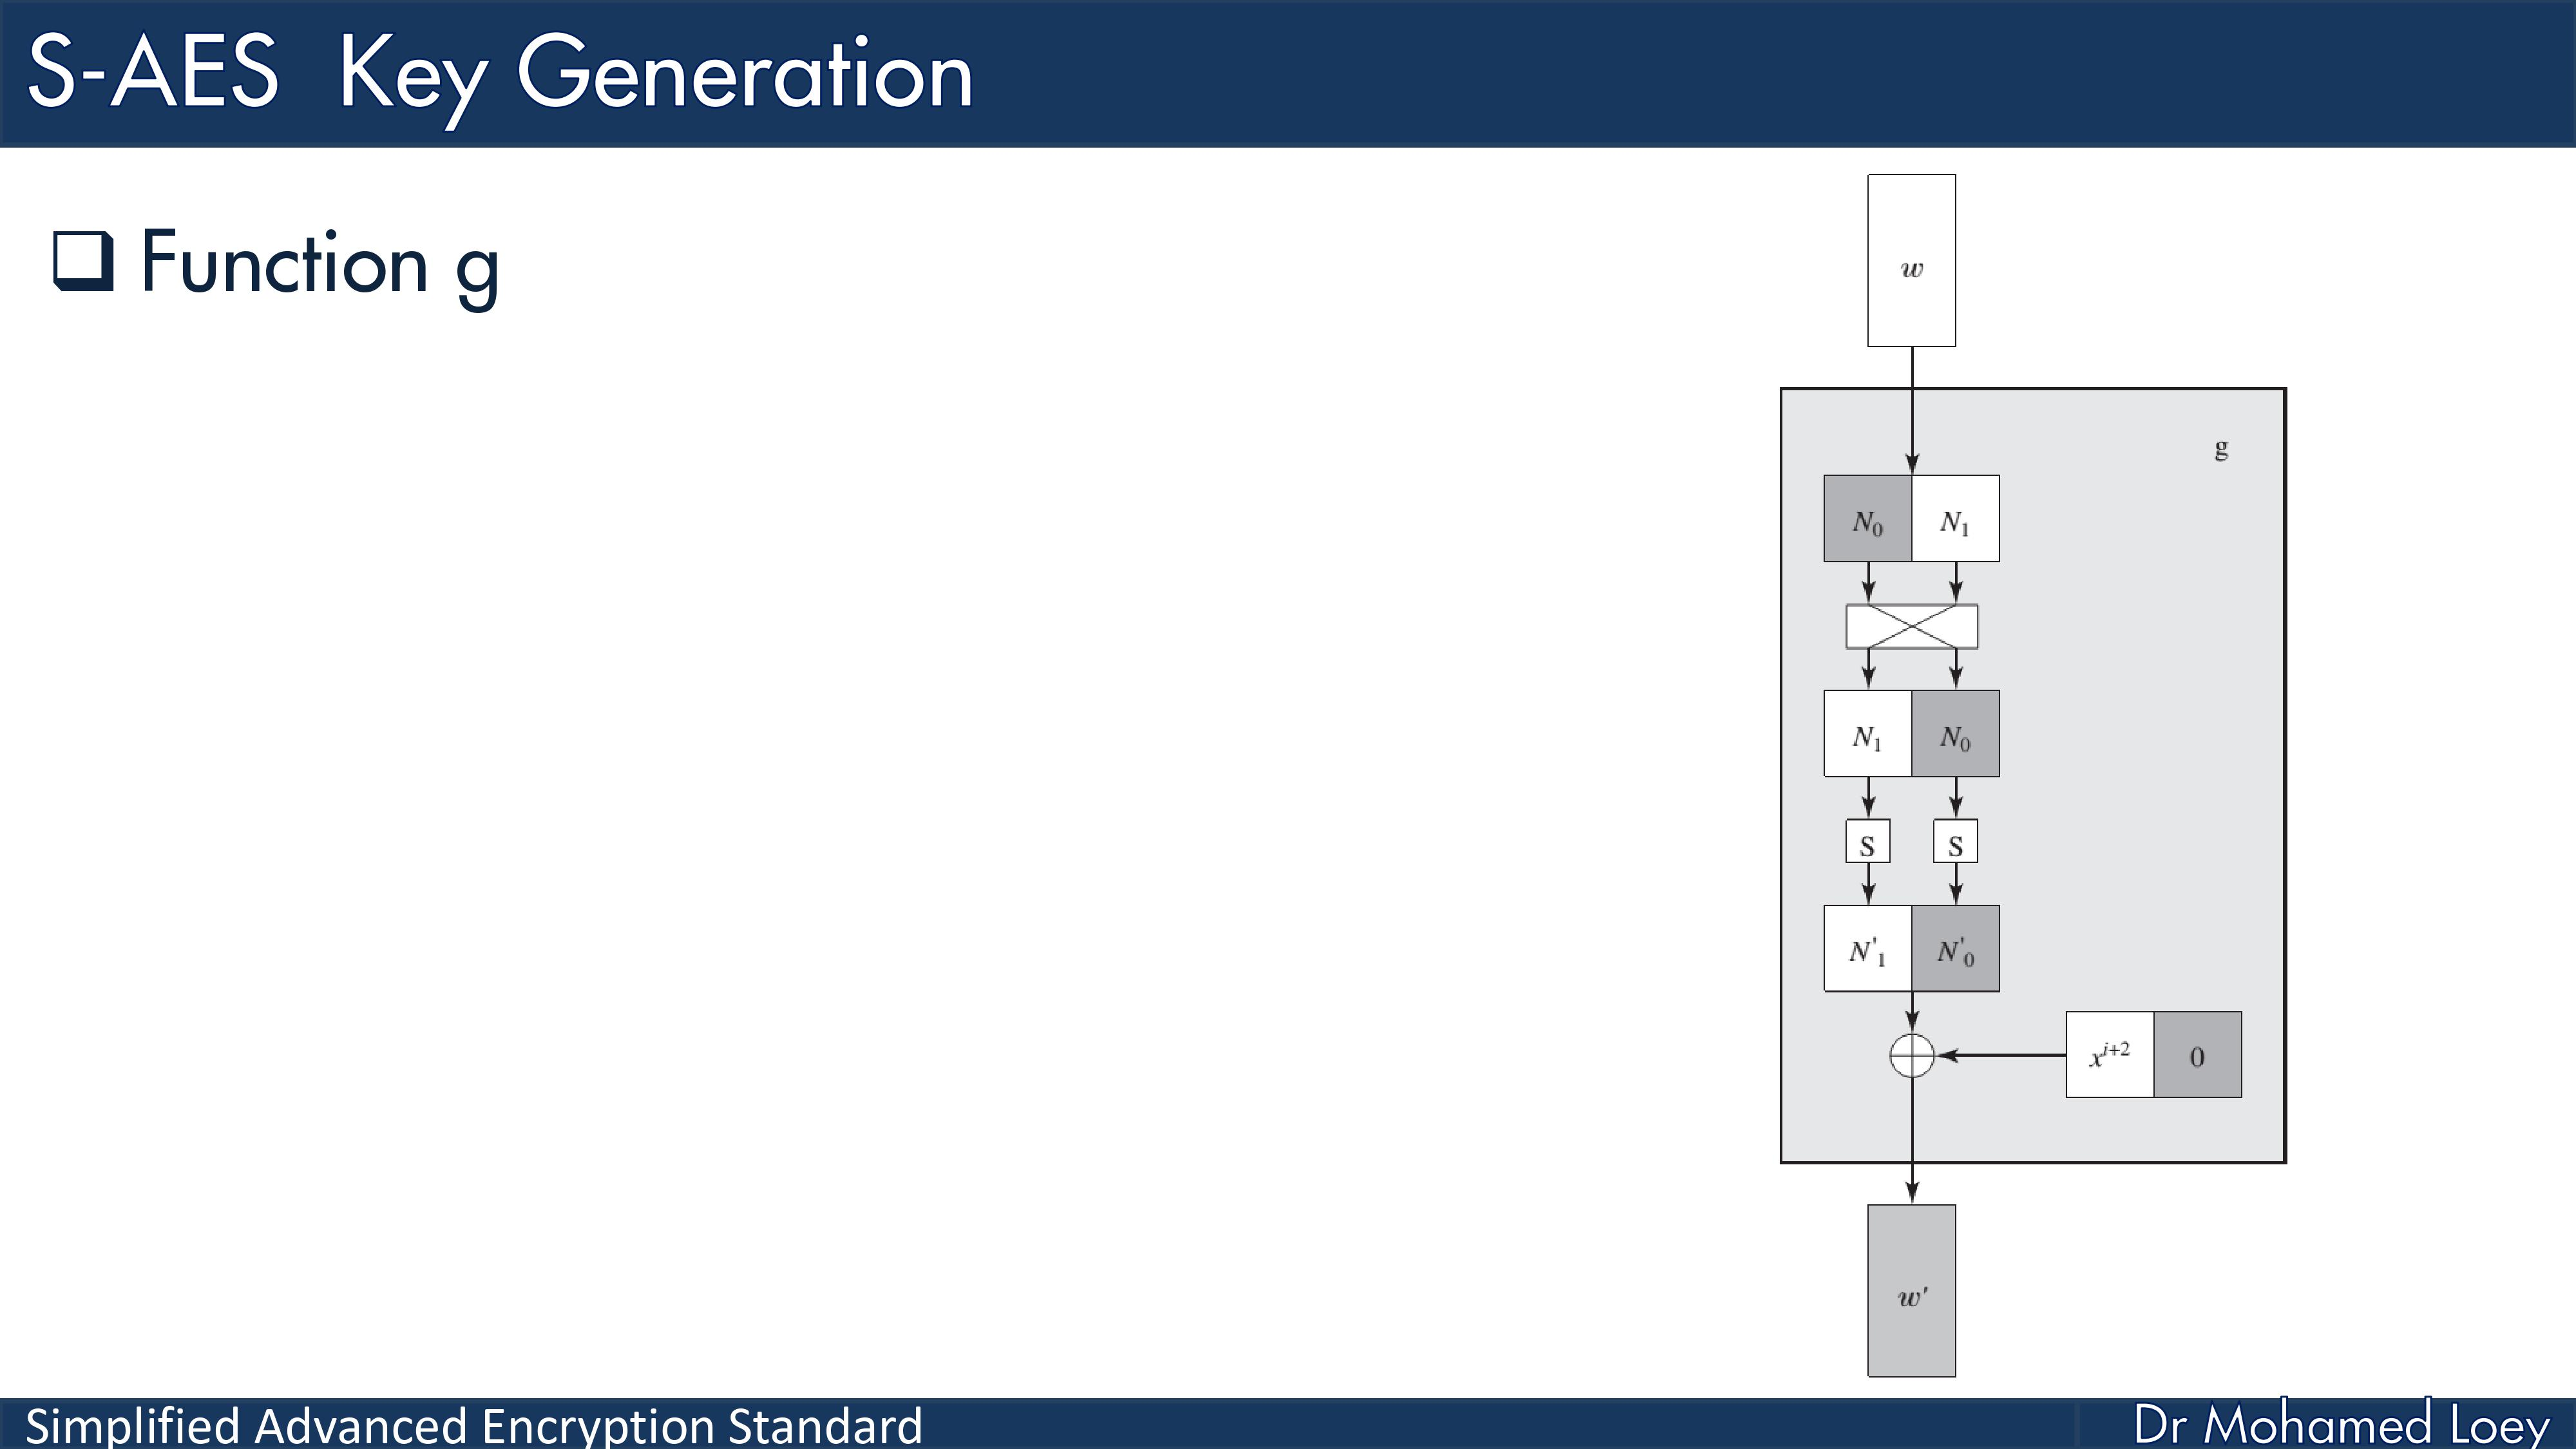

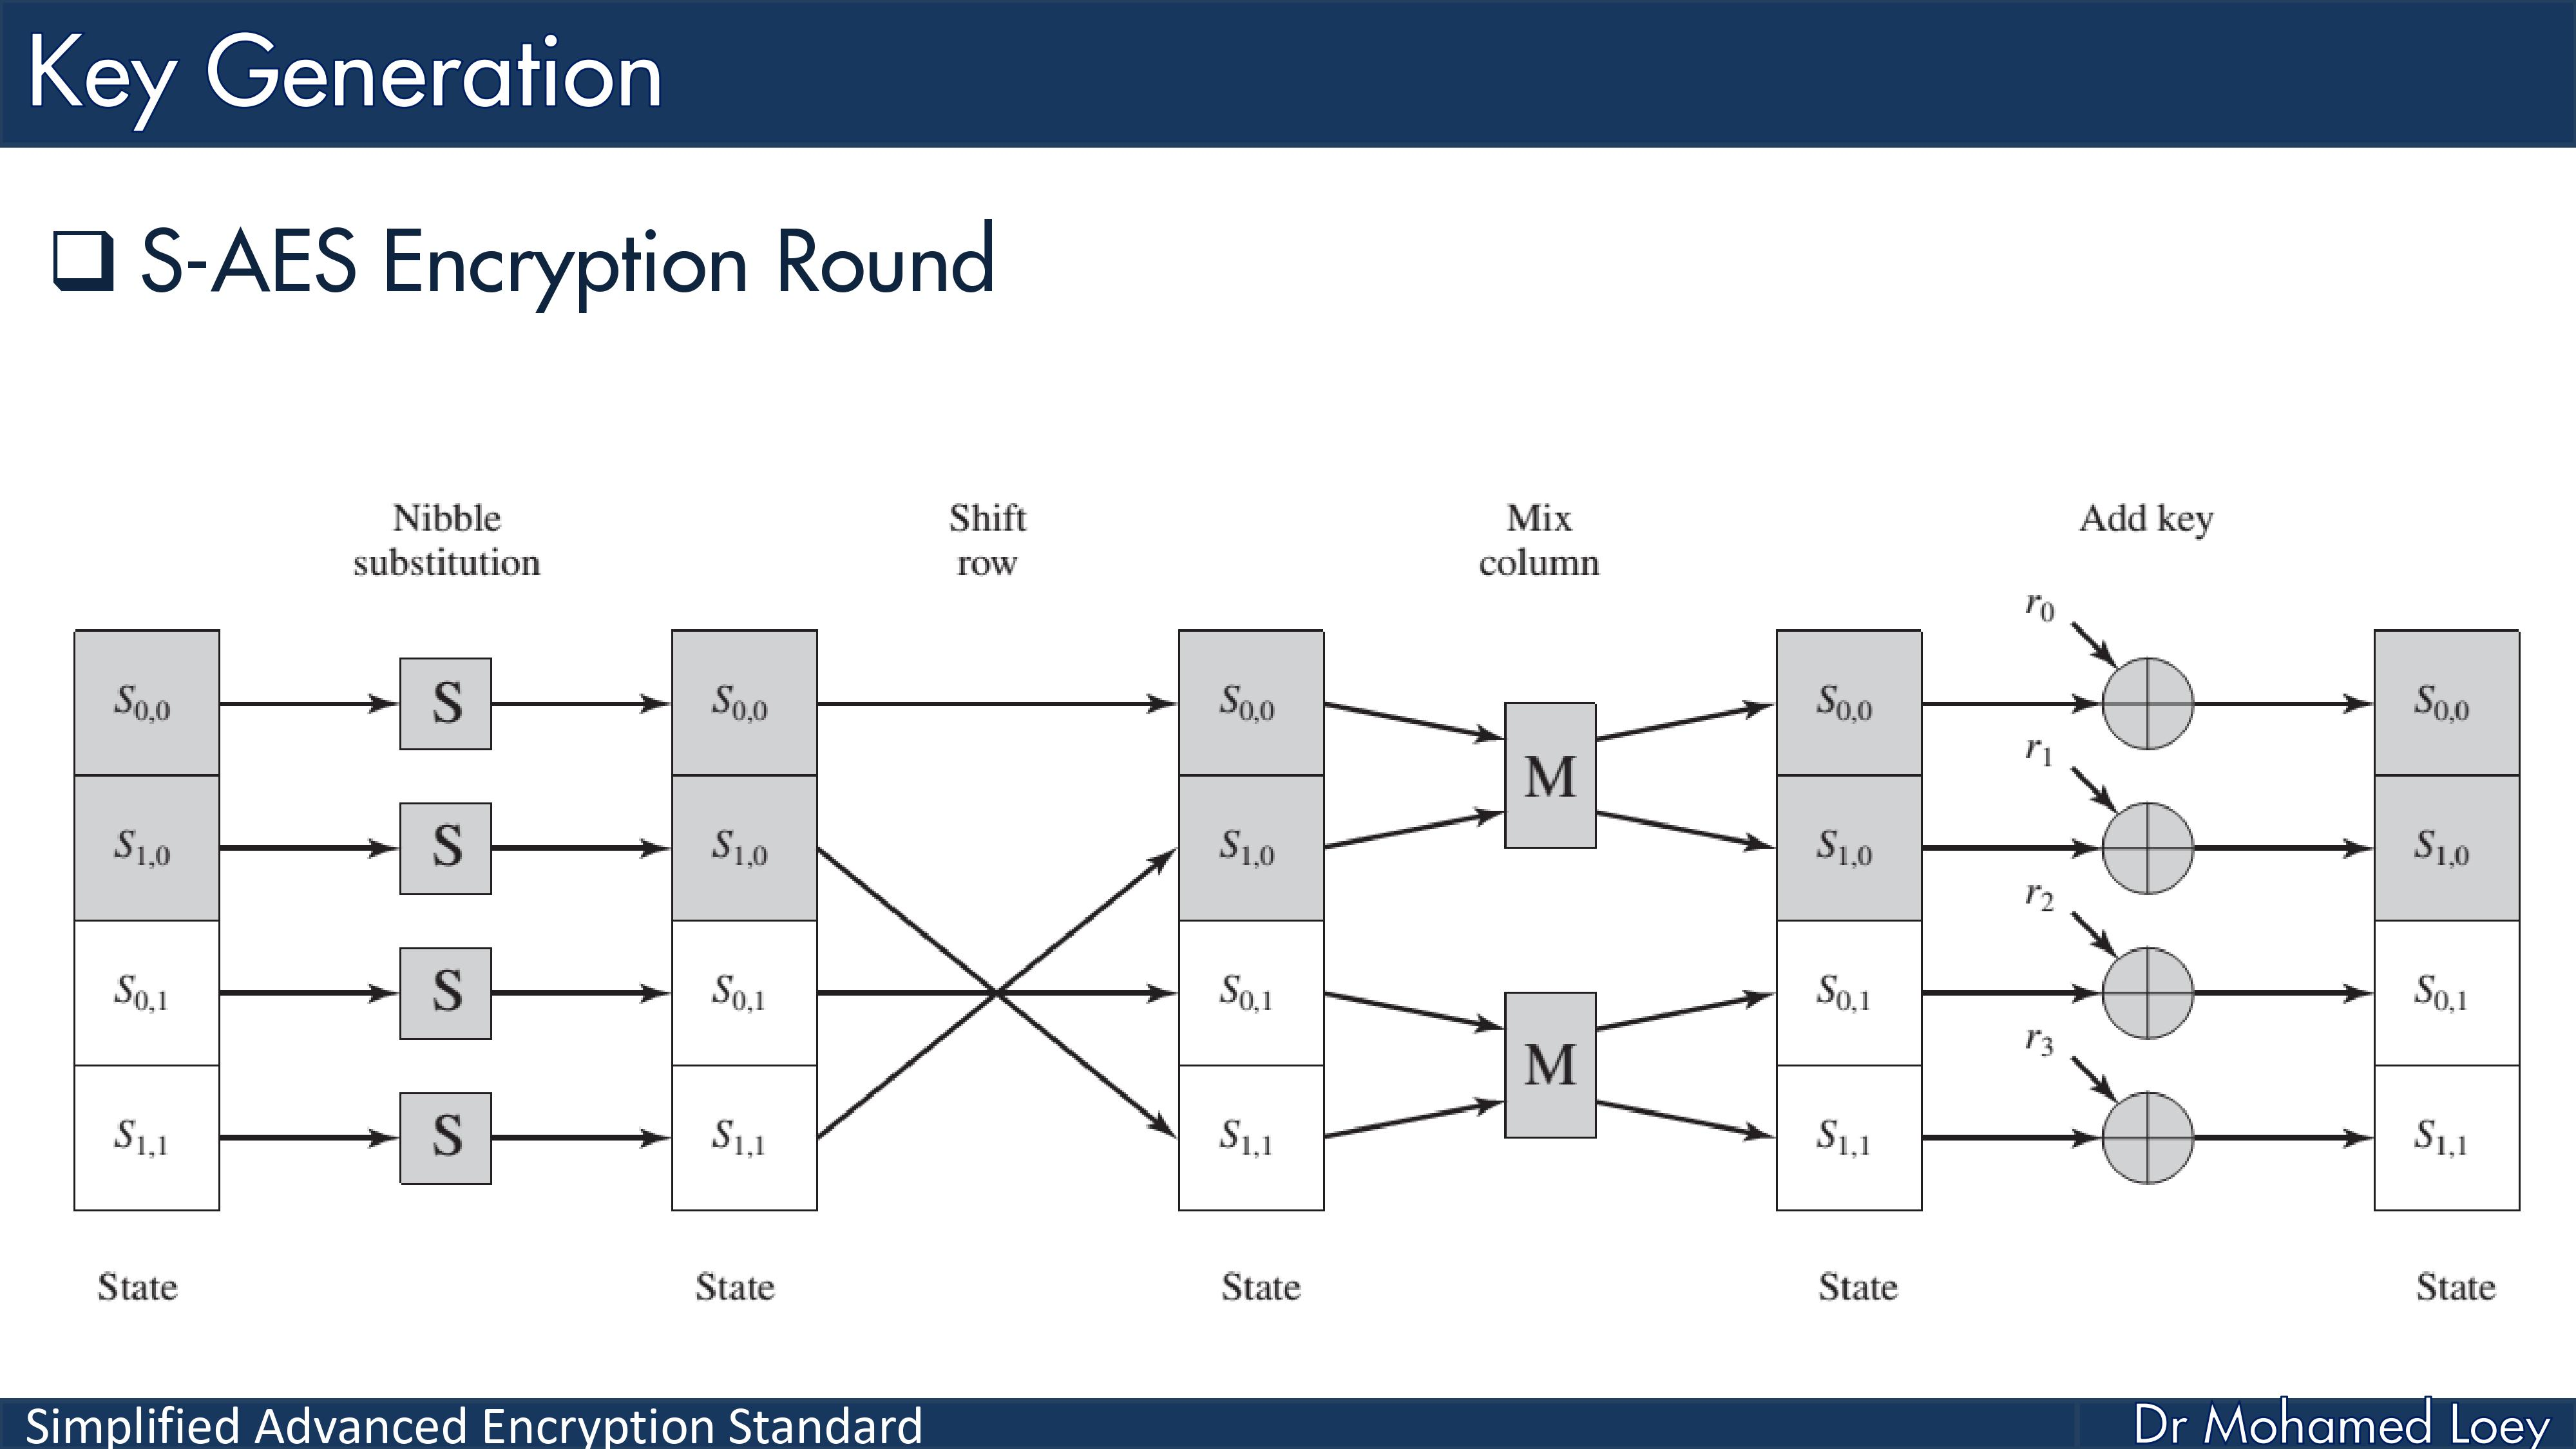

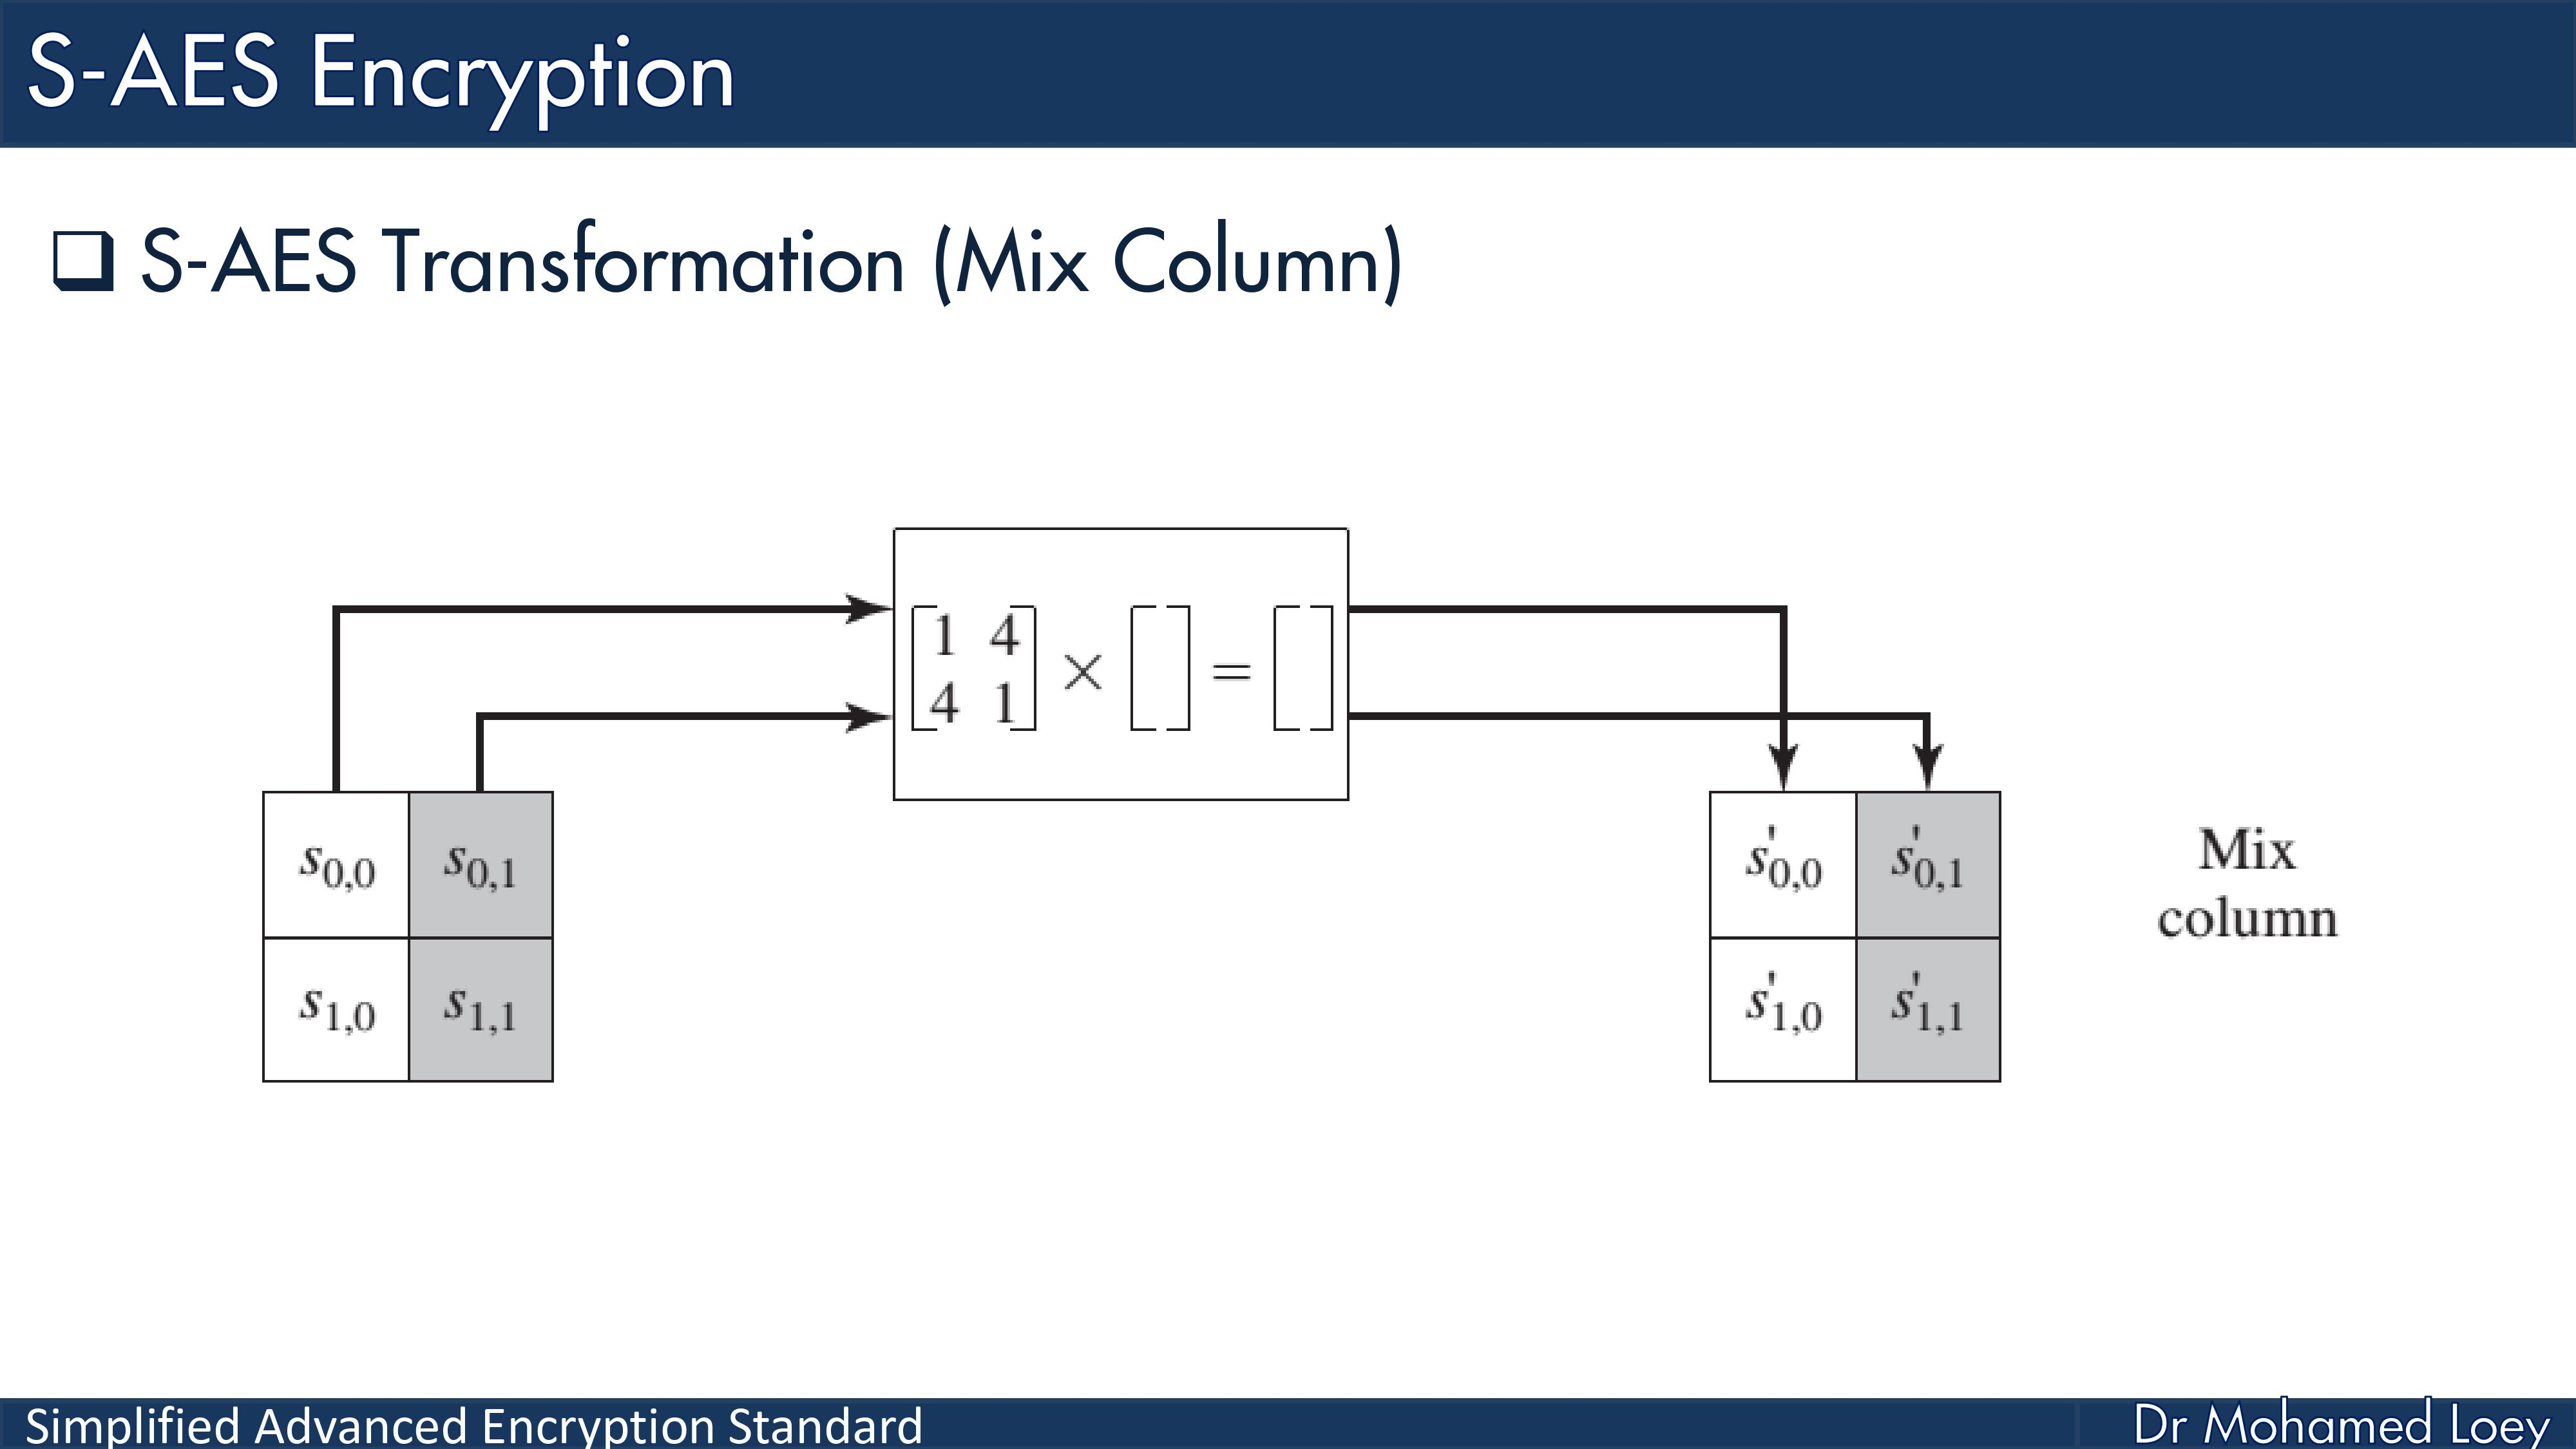

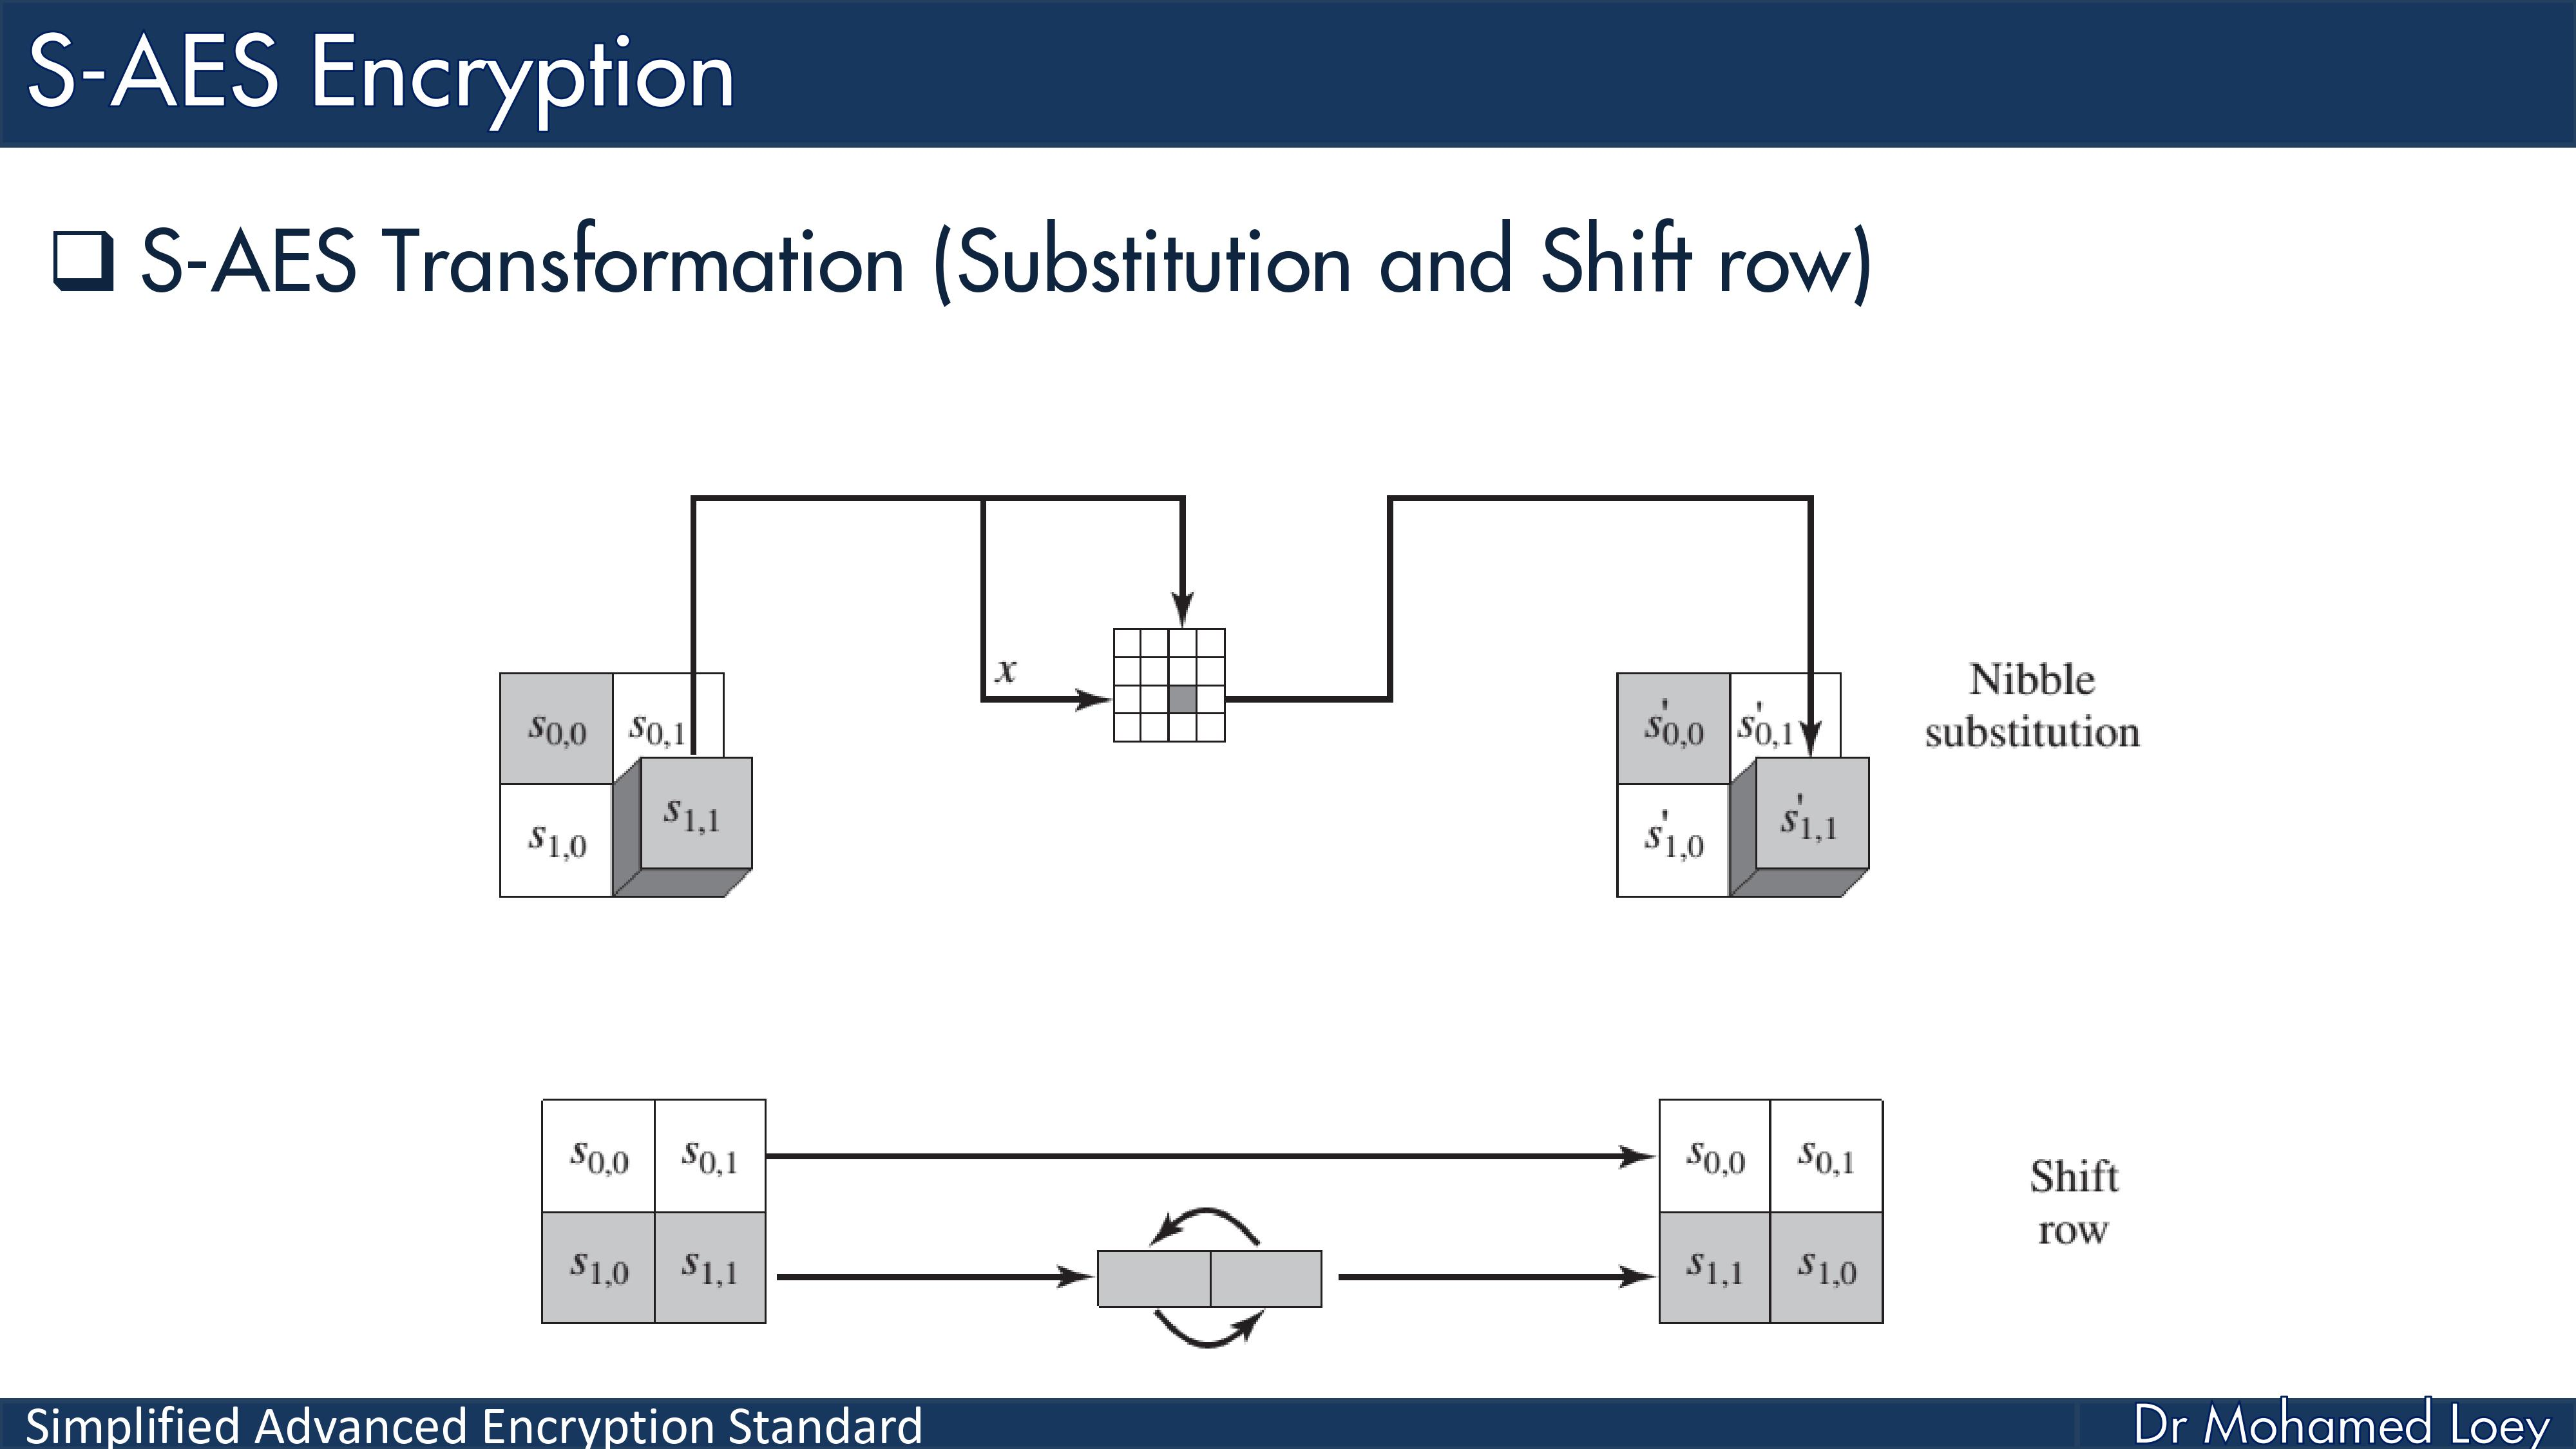

#Source Code

In [1]:
!pip install GaloisField

In [2]:
# Helper Functions

def rot_nib(bits):
  return bits[int(len(bits)/2):]+bits[0:int(len(bits)/2)] #swap the right nibble and the left nibble hehe

def xor(operand1, operand2):
  return [ bit1^bit2 for bit1, bit2 in zip(operand1, operand2) ]

def int2nibble(val):
  result = bin(val)[2:] #Get byte format in string and remove '0b'
  result = '0'*(4-len(result)) + result #Padding (4 bit)
  result = [int(x) for x in result] #Convert result string to an array of 0s and 1s
  return result


#s-box has hexadecimal values (did not include the byte values for easier readability)

s_box_enc = [ [0x9,0x4,0xa,0xb],
              [0xd,0x1,0x8,0x5],
              [0x6,0x2,0x0,0x3],
              [0xc,0xe,0xf,0x7] ]

s_box_dec = [ [0xa,0x5,0x9,0xb],
              [0x1,0x7,0x8,0xf],
              [0x6,0x0,0x2,0x3],
              [0xc,0x4,0xd,0xe] ]

def sub_nib(bits, s_box):
  result = []
  assert len(bits)%4==0 #input bits should form complete nibbles hehe
  for i in range(0,len(bits),4):  #For each nibble
    index_i = 2*bits[i]+bits[i+1] #first two bits are the row index of the s-box
    index_j = 2*bits[i+2]+bits[i+3] #last two bits are the column index of the s-box
    val = s_box[index_i][index_j] #get the value from the s-box
    nibble_bytearray = int2nibble(val)  #get the corresponding nibble
    result = result + nibble_bytearray  #append the nibble to the result
  return result



# Helper function for galois_multiplication
def nibble2container(nibble):
  container = {}
  nibble.reverse()
  for index, degree in enumerate(nibble):
    if degree == 1:
      container[index] = degree
  nibble.reverse()
  return container

# Helper function for galois_multiplication
def container2nibble(container):
  nibble = [0]*4
  for index in container.keys():
    nibble[index] = container[index]
  nibble.reverse()
  return nibble

def galois_multiplication(operator1, operator2):
  from galois_field.GF import GF, FFElement
  from galois_field.fast_polynom import FastPolynom
  irr_poly = FastPolynom({0: 1, 1: 1, 2:0, 4: 1}) # Irreversible Polynomial x^4 + x + 1
  ff = GF(2, 4, irr_poly) # GF(2^4)
  e1 = FFElement(ff, FastPolynom(nibble2container(operator1)))
  e2 = FFElement(ff, FastPolynom(nibble2container(operator2)))
  e_res = e1 * e2
  result = container2nibble(e_res.container.container)
  return result


def mix_col(bits):
  '''
  Matrix Multiplication : S' = S * Me

  S = [ S00   S01
        S10   S11]

  S = S00 S10 S01 S11

  S' = [S00'  S01'
        S10'  S11']

  Me = [1   4
        4   1]
  '''
  FOUR = [0,1,0,0]
  s00 = bits[0:4]
  s10 = bits[4:8]
  s01 = bits[8:12]
  s11 = bits[12:]
  s00_ = xor(
      s00,
      galois_multiplication(FOUR, s10)
    )
  s10_ = xor(
      galois_multiplication(FOUR, s00),
      s10
    )
  s01_ = xor(
      s01,
      galois_multiplication(FOUR, s11)
    )
  s11_ = xor(
      galois_multiplication(FOUR, s01),
      s11
    )
  result = s00_ + s10_ + s01_ + s11_
  return result

# Swap the second and the fourth nibble
def shift_row(bits):
  return bits[0:4] + bits[12:] + bits[8:12] + bits[4:8]


def mix_col_inv(bits):
  '''
  Matrix Multiplication : S' = S * Me

  S = [ S00   S01
        S10   S11]

  S = S00 S10 S01 S11

  S' = [S00'  S01'
        S10'  S11']

  Me = [9   2
        2   9]
  '''
  NINE = [1,0,0,1]
  TWO = [0,0,1,0]
  s00 = bits[0:4]
  s10 = bits[4:8]
  s01 = bits[8:12]
  s11 = bits[12:]
  s00_ = xor(
      galois_multiplication(NINE, s00),
      galois_multiplication(TWO, s10)
    )
  s10_ = xor(
      galois_multiplication(TWO, s00),
      galois_multiplication(NINE, s10)
    )
  s01_ = xor(
      galois_multiplication(NINE, s01),
      galois_multiplication(TWO, s11)
    )
  s11_ = xor(
      galois_multiplication(TWO, s01),
      galois_multiplication(NINE, s11)
    )
  result = s00_ + s10_ + s01_ + s11_
  return result


In [3]:
# class SAES

class SAES:


  def key_generation(self, key):

    w0 = key[0:8]
    w1 = key[8:]
    
    RCON1 = [1,0,0,0,0,0,0,0]  #round constant 1
    w2 = xor(xor(w0,RCON1),sub_nib(rot_nib(w1),s_box_enc))
    w3 = xor(w1,w2)
    
    RCON2 = [0,0,1,1,0,0,0,0]  #round constant 2
    w4 = xor(xor(w2,RCON2),sub_nib(rot_nib(w3),s_box_enc))
    w5 = xor(w3,w4)
    
    key0 = key
    key1 = w2+w3
    key2 = w4+w5
    
    return key0, key1, key2


  def encryption(self, plain_text, key):

    #key generation
    key0,key1,key2 = self.key_generation(key)

    #Round 0 - add round key
    r0 = xor(plain_text, key0)
    
    #Round 1
    r1 = sub_nib(r0,s_box_enc)  #nibble substitution
    r1 = shift_row(r1) #shift row - swap 2nd nibble and 4th nibble
    r1 = mix_col(r1) #mix columns
    r1 = xor(r1, key1) #add round key

    #Round 2
    r2 = sub_nib(r1,s_box_enc)  #nibble substitution
    r2 = shift_row(r2) #shift row - swap 2nd nibble and 4th nibble
    r2 = xor(r2, key2) #add round key
    
    return r2 #resultant cipher text


  def decryption(self, cipher_text, key):

    #key generation
    key0,key1,key2 = self.key_generation(key)

    #Round 0 - add round key
    r2 = xor(cipher_text, key2)
    
    #Round 1
    r2 = shift_row(r2) #inverse shift row - swap 2nd nibble and 4th nibble
    r2 = sub_nib(r2,s_box_dec)  #inverse nibble substitution
    r1 = xor(r2, key1) #add round key

    #Round 2
    r1 = mix_col_inv(r1) #mix columns
    r1 = shift_row(r1) #inverse shift row - swap 2nd nibble and 4th nibble
    r1 = sub_nib(r1,s_box_dec)  #inverse nibble substitution
    r0 = xor(r1, key0) #add round key

    return r0  #resultant decrypted text


In [4]:
# Sample Execution Byte Level

saes = SAES()
plain_text = [1,1,0,1,0,1,1,1,0,0,1,0,1,0,0,0]
key = [0,1,0,0,1,0,1,0,1,1,1,1,0,1,0,1]
cipher_text = saes.encryption(plain_text, key)
decrypted_text = saes.decryption(cipher_text, key)
print('Plain Text = ', plain_text)
print('Cipher Text = ', cipher_text)
print('Decrypted Text = ', decrypted_text)
print('isDecrypted = ',plain_text==decrypted_text)

Plain Text =  [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Cipher Text =  [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]
Decrypted Text =  [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
isDecrypted =  True


In [5]:
# Encrypt a string of text

def encrypt_text(plain_text, key_bytearray=[0,1,0,0,1,0,1,0,1,1,1,1,0,1,0,1]):

  index = 0
  byte1 = ''
  byte2 = ''

  saes = SAES()
  encrypted_text = ''

  # Pad with ascii 0
  if len(plain_text)%2 == 1:
    plain_text += chr(0)

  # Select two characters at a time
  for byte in bytearray(plain_text, "utf8"):
    
    if index%2 == 0:
      byte1 = byte  
    else:
      byte2 = byte

      # byte to bytestring
      binrep1, binrep2 = bin(byte1), bin(byte2)
      
      # Remove '0b' from bytestring
      binrep1, binrep2 = binrep1[2:], binrep2[2:]
      
      # Padding with 0s
      binrep1, binrep2 = '0'*(8-len(binrep1))+binrep1, '0'*(8-len(binrep2))+binrep2
      
      # Combine the binary representations
      binary_representation = binrep1 + binrep2

      # Encrypt using Simplified AES
      cipher_text_bytearray = saes.encryption([int(x) for x in list(binary_representation)], key_bytearray)

      # Convert bytearray to character
      binary_representation_cipher = ''
      for digit in cipher_text_bytearray:
        binary_representation_cipher += str(digit)

      # Convert encoded text to utf-8
      encrypted_text = encrypted_text + chr(int(binary_representation_cipher[0:8],2)) + chr(int(binary_representation_cipher[8:],2))

    index += 1

  return encrypted_text


plain_text = "Sos1!"
cipher_text = encrypt_text(plain_text)
print('Plain Text = ', plain_text)
print('Cipher Text = ', cipher_text)

Plain Text =  Sos1!
Cipher Text =  ­ÀÐ/Ê


In [6]:
# Decrypt a string of text

def decrypt_text(cipher_text, key_bytearray=[0,1,0,0,1,0,1,0,1,1,1,1,0,1,0,1]):

  saes = SAES()
  decrypted_text = ''

  # Take two characters at a time
  for character1, character2 in zip(cipher_text[0::2], cipher_text[1::2]):

    # Convert from character to ascii to bytestring
    # Remove '0b' from bytestring
    binrep1, binrep2 = bin(ord(character1))[2:], bin(ord(character2))[2:]
    
    # Pad with zeroes to create 8-bit array of 1s and 0s
    binrep1, binrep2 = '0'*(8-len(binrep1))+binrep1, '0'*(8-len(binrep2))+binrep2
    
    # Join the binary representation of two characters
    binary_representation = binrep1 + binrep2

    # Decrypt using Simplified AES
    decrypted_text_bytearray = saes.decryption([int(x) for x in list(binary_representation)], key_bytearray)
    
    # Convert array to bytestring
    binary_representation_decrypted = ''
    for digit in decrypted_text_bytearray:
      binary_representation_decrypted += str(digit)
    
    # Convert array to int to char
    # Append the two characters to decrypted_text
    decrypted_text = decrypted_text + chr(int(binary_representation_decrypted[0:8],2)) + chr(int(binary_representation_decrypted[8:],2))

  # If last character is ascii value 0, delete it
  if decrypted_text[-1] == chr(0):
    decrypted_text = decrypted_text[0:-1]

  return decrypted_text


decrypted_text = decrypt_text(cipher_text)
print('Cipher Text = ', cipher_text)
print('Decrypted Text = ', decrypted_text)

Cipher Text =  ­ÀÐ/Ê
Decrypted Text =  Sos1!


In [7]:
print('Plain Text = ', plain_text)
print('Cipher Text = ', cipher_text)
print('Decrypted Text = ', decrypted_text)
print('isDecrypted = ',plain_text==decrypted_text)

Plain Text =  Sos1!
Cipher Text =  ­ÀÐ/Ê
Decrypted Text =  Sos1!
isDecrypted =  True


In [8]:
plain_text = "AAA"
cipher_text = encrypt_text(plain_text)
decrypted_text = decrypt_text(cipher_text)
print('Plain Text = ', plain_text)
print('Cipher Text = ', cipher_text)
print('Decrypted Text = ', decrypted_text)
print('isDecrypted = ',plain_text==decrypted_text)

Plain Text =  AAA
Cipher Text =  E
Decrypted Text =  AAA
isDecrypted =  True
